In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
DATA_DIR = '../data/10xpbmc3k-2020/'

# Load the Data

In [4]:
scdata = sc.read_10x_h5(DATA_DIR + 'pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5', gex_only=False)
scdata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2714 × 193208
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
scrna = scdata[:, scdata.var['feature_types'] == 'Gene Expression']
scatac = scdata[:, scdata.var['feature_types'] == 'Peaks']
scrna, scatac

(View of AnnData object with n_obs × n_vars = 2714 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 2714 × 156607
     var: 'gene_ids', 'feature_types', 'genome')

# scRNA-seq Data

In [6]:
scrna.obs.head()

""
AAACAGCCAAATATCC-1
AAACAGCCAGGAACTG-1
AAACAGCCAGGCTTCG-1
AAACCAACACCTGCTC-1
AAACCAACAGATTCAT-1


In [7]:
scrna.var.head()

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38


## Data Cleaning

In [8]:
scrna_clusters = pd.read_csv(DATA_DIR + 'analysis/clustering/gex/graphclust/clusters.csv', index_col=0)
scrna_clusters = scrna_clusters.astype('category')
scrna_clusters = scrna_clusters.rename(columns={'Cluster': 'cell_type'})
scrna_clusters.head()

,cell_type
Barcode,
AAACAGCCAAATATCC-1,5
AAACAGCCAGGAACTG-1,3
AAACAGCCAGGCTTCG-1,4
AAACCAACACCTGCTC-1,5
AAACCAACAGATTCAT-1,5


In [9]:
scrna.obs = scrna.obs.join(scrna_clusters, how='left', sort=False)
scrna.obs.head()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,cell_type
AAACAGCCAAATATCC-1,5
AAACAGCCAGGAACTG-1,3
AAACAGCCAGGCTTCG-1,4
AAACCAACACCTGCTC-1,5
AAACCAACAGATTCAT-1,5


# Quality Control

In [10]:
scrna.var_names_make_unique()

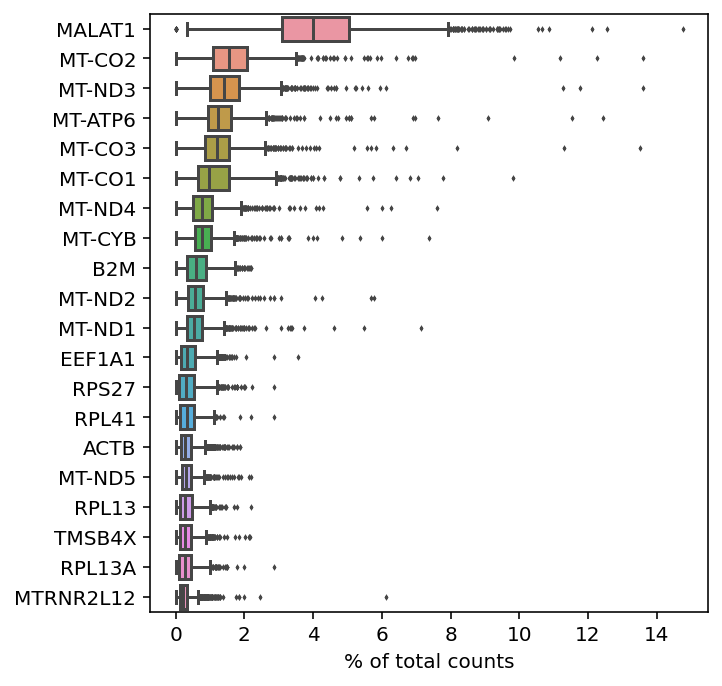

In [11]:
sc.pl.highest_expr_genes(scrna, n_top=20)

In [12]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna

AnnData object with n_obs × n_vars = 2705 × 21254
    obs: 'cell_type', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Qalculate QC metrics including Mitochondrial genes

In [13]:
scrna.var['mt'] = scrna.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 2705 × 21254
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'feature_types' as categorical
... storing 'genome' as categorical


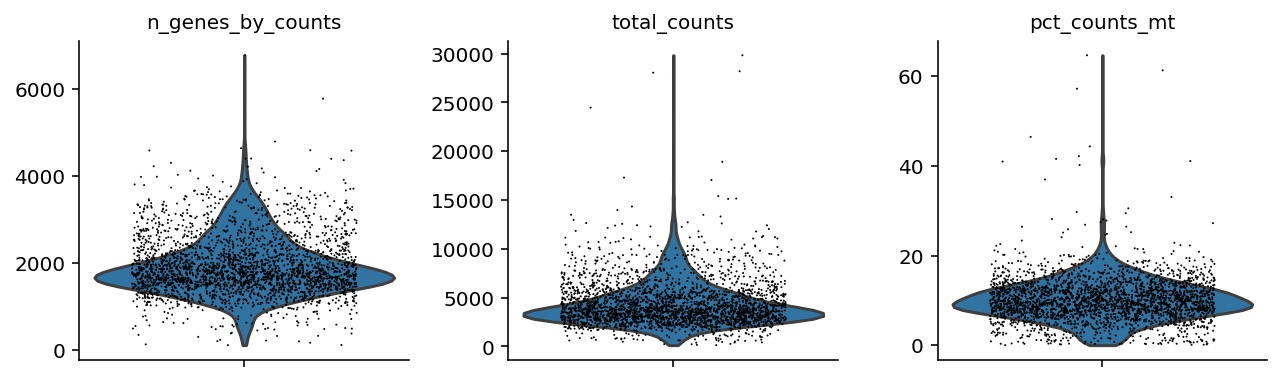

In [14]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

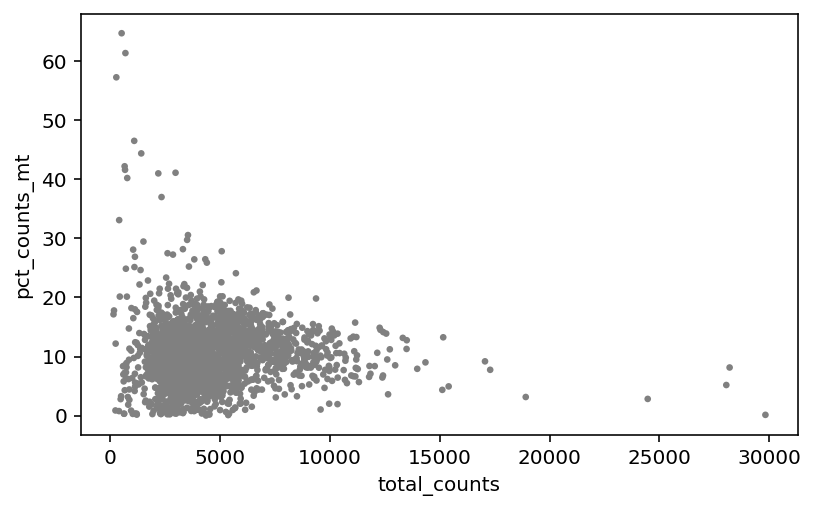

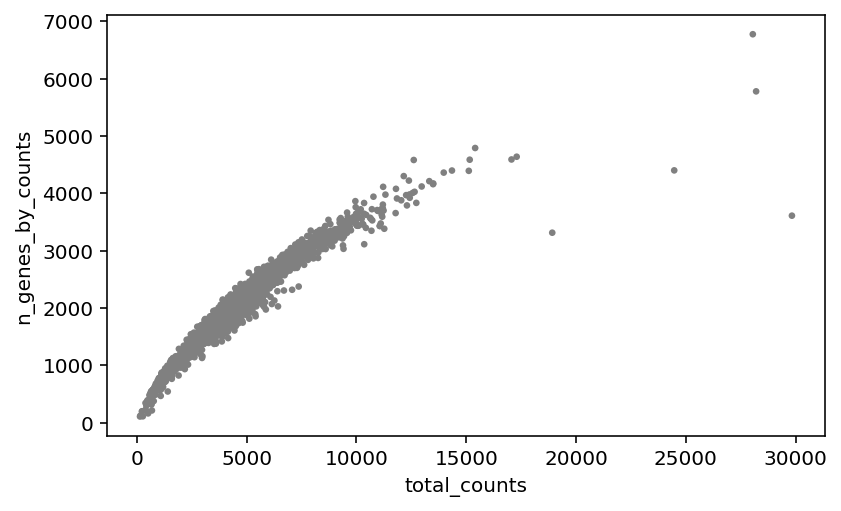

In [15]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

Filter out high mitochondrial samples and samples with highest number of genes:

In [16]:
scrna = scrna[scrna.obs.n_genes_by_counts < 4000, :]
scrna = scrna[scrna.obs.pct_counts_mt < 20, :]
scrna

View of AnnData object with n_obs × n_vars = 2628 × 21254
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization

In [17]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

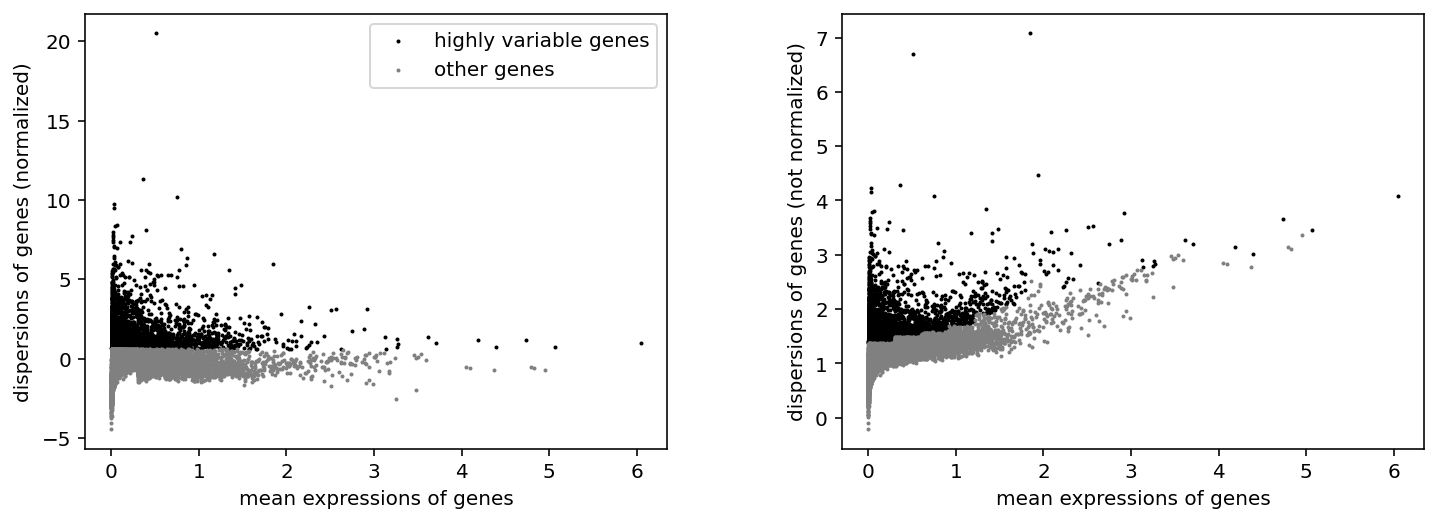

In [18]:
sc.pp.highly_variable_genes(scrna, n_top_genes=4000)
sc.pl.highly_variable_genes(scrna)

In [19]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 2628 × 4000
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Visualization

### Running UMAP

In [20]:
sc.pp.neighbors(scrna)
sc.tl.umap(scrna)

         Falling back to preprocessing with `sc.pp.pca` and default params.


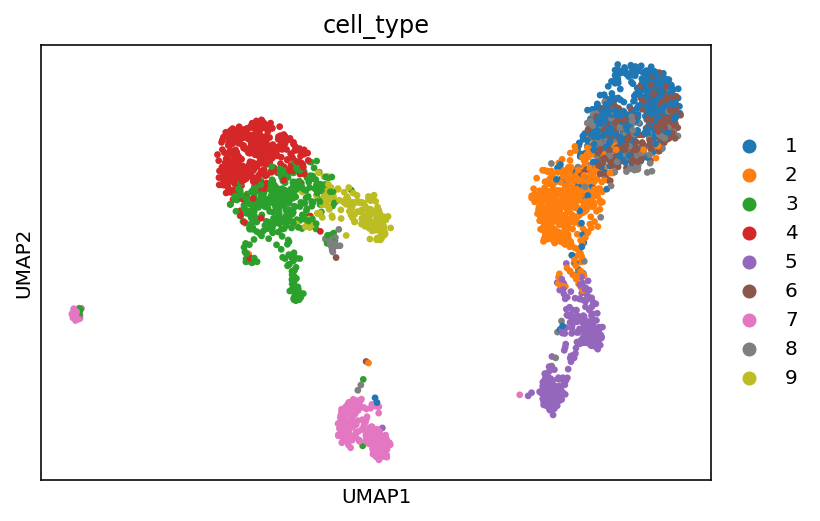

In [21]:
sc.pl.umap(scrna, color=['cell_type'])

---
# scATAC-seq Data

In [22]:
scatac.obs

""
AAACAGCCAAATATCC-1
AAACAGCCAGGAACTG-1
AAACAGCCAGGCTTCG-1
AAACCAACACCTGCTC-1
AAACCAACAGATTCAT-1
...
TTTGTGGCATTAGCCA-1
TTTGTGGCATTGCGAC-1
TTTGTGTTCCGCCTAT-1
TTTGTGTTCCGTGACA-1


In [23]:
scatac.var.head()

,gene_ids,feature_types,genome
chr1:9986-10403,chr1:9986-10403,Peaks,GRCh38
chr1:180690-181695,chr1:180690-181695,Peaks,GRCh38
chr1:191335-192015,chr1:191335-192015,Peaks,GRCh38
chr1:267775-268224,chr1:267775-268224,Peaks,GRCh38
chr1:271144-271510,chr1:271144-271510,Peaks,GRCh38


## Data Cleaning

In [24]:
scatac_clusters = pd.read_csv(DATA_DIR + 'analysis/clustering/atac/graphclust/clusters.csv', index_col=0)
scatac_clusters = scatac_clusters.astype('category')
scatac_clusters = scatac_clusters.rename(columns={'Cluster': 'cell_type'})
scatac_clusters.head()

,cell_type
Barcode,
AAACAGCCAAATATCC-1,6
AAACAGCCAGGAACTG-1,3
AAACAGCCAGGCTTCG-1,1
AAACCAACACCTGCTC-1,8
AAACCAACAGATTCAT-1,6


In [25]:
scatac.obs = scatac.obs.join(scatac_clusters, how='left', sort=False)
scatac.obs.head()

,cell_type
AAACAGCCAAATATCC-1,6
AAACAGCCAGGAACTG-1,3
AAACAGCCAGGCTTCG-1,1
AAACCAACACCTGCTC-1,8
AAACCAACAGATTCAT-1,6


## Quality Control

### Basic filtering

In [26]:
epi.pp.filter_features(scatac, min_cells=1)
epi.pp.filter_cells(scatac, min_features=1)
scatac

AnnData object with n_obs × n_vars = 2714 × 151489
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Binarization

In [27]:
%time epi.pp.binarize(scatac)
scatac

CPU times: user 1.49 s, sys: 164 ms, total: 1.65 s
Wall time: 1.65 s


AnnData object with n_obs × n_vars = 2714 × 151489
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Filter low quality cells and peaks

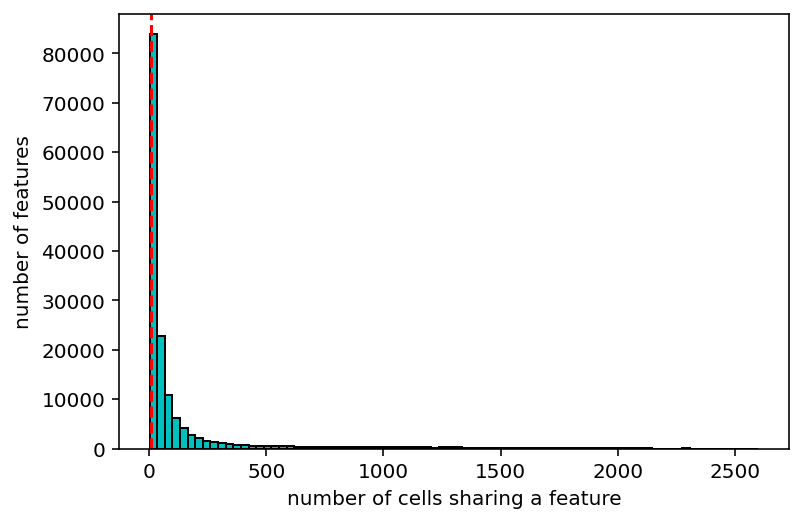

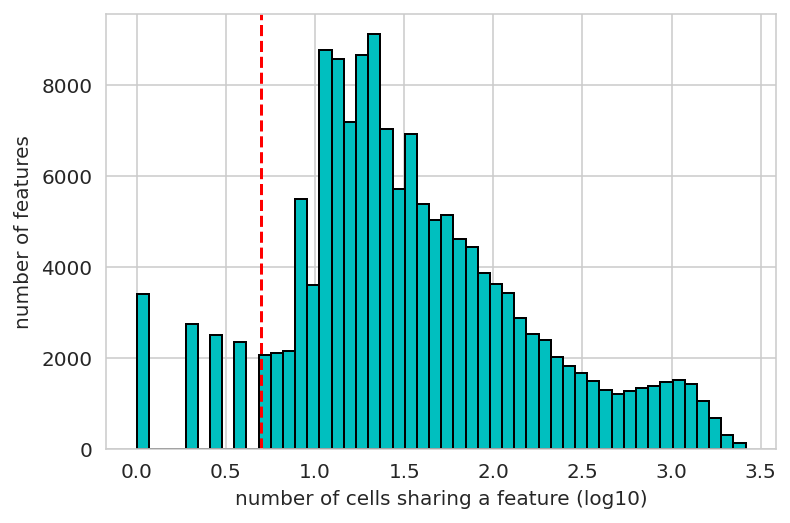

In [28]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=5)
epi.pp.coverage_features(scatac, binary=True, log=10, bins=50, threshold=5)

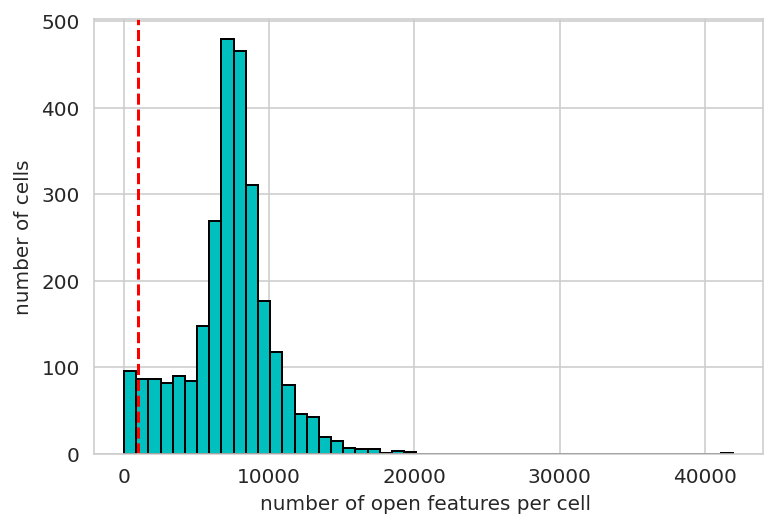

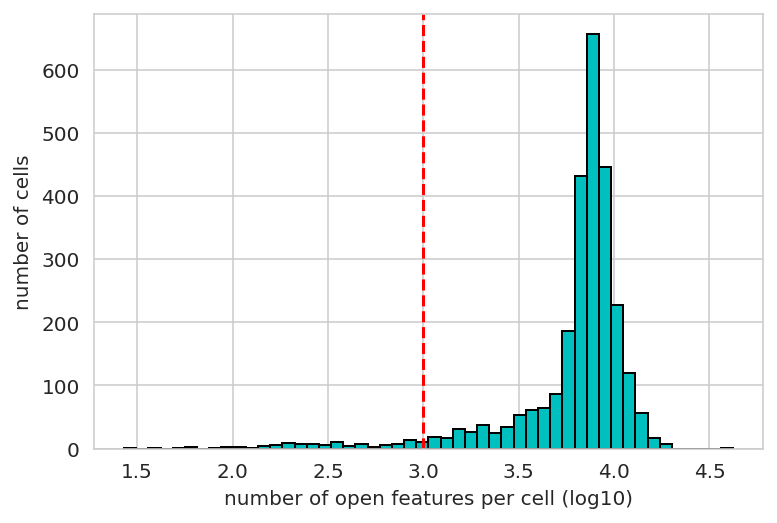

In [29]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=1000)

In [30]:
epi.pp.filter_cells(scatac, min_features=1000)
epi.pp.filter_features(scatac, min_cells=5)
scatac

AnnData object with n_obs × n_vars = 2605 × 140508
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

Filtering cells with high open peaks and peaks with high number of cells:

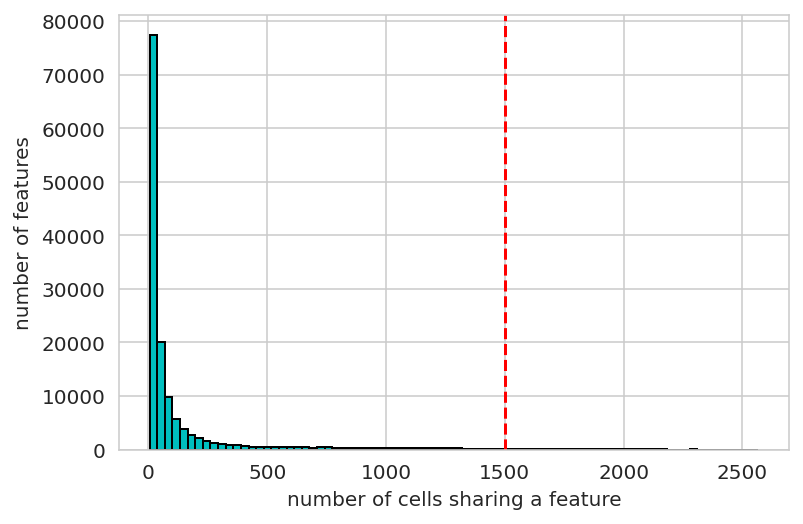

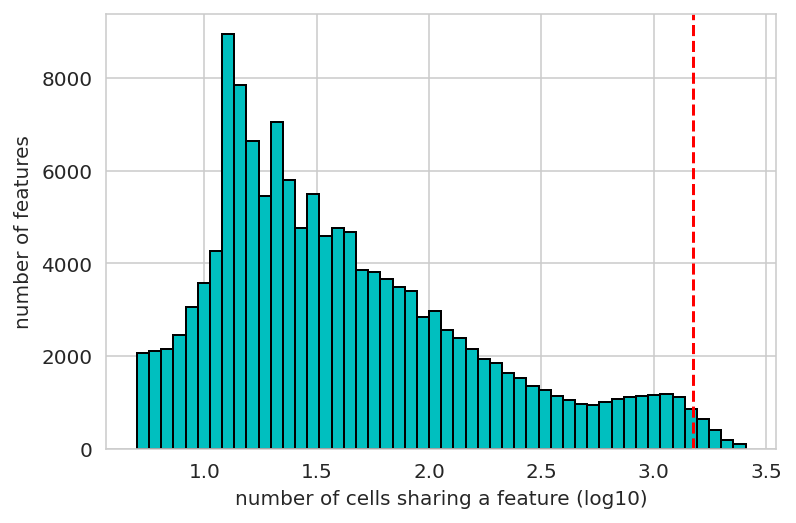

In [31]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=1500)
epi.pp.coverage_features(scatac, binary=True, log=True, bins=50, threshold=1500)

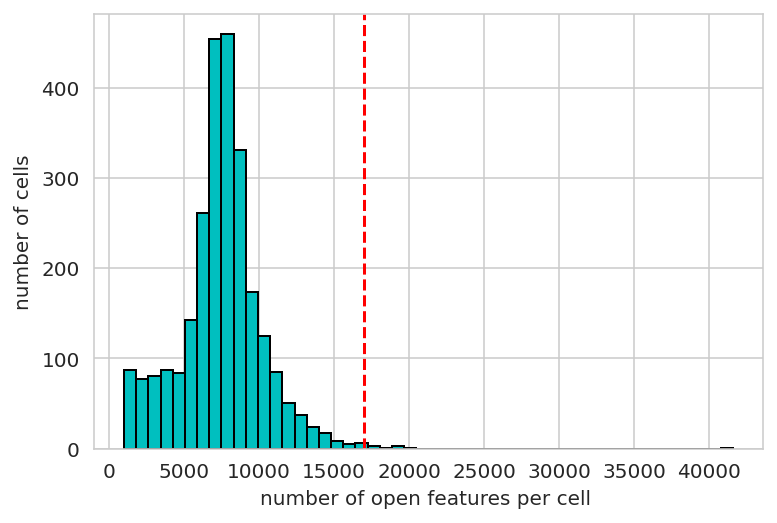

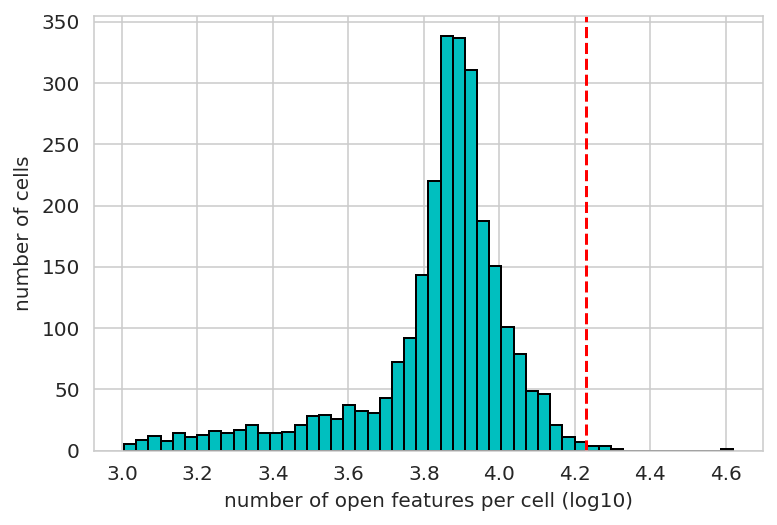

In [32]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=17000)
epi.pp.coverage_cells(scatac, binary=True, log=True, bins=50, threshold=17000)

In [33]:
epi.pp.filter_cells(scatac, max_features=17000)
epi.pp.filter_features(scatac, max_cells=1500)
scatac

AnnData object with n_obs × n_vars = 2595 × 138978
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

In [34]:
scatac.obs['nb_features'].describe()

count     2595.000000
mean      7423.303276
std       2648.440972
min       1013.000000
25%       6209.500000
50%       7533.000000
75%       8743.000000
max      16942.000000
Name: nb_features, dtype: float64

In [35]:
scatac.var['commonness'].describe()

count    138978.000000
mean        120.371980
std         242.082107
min           5.000000
25%          15.000000
50%          31.000000
75%          89.000000
max        1509.000000
Name: commonness, dtype: float64

In [36]:
scatac.var['commonness'].median()

31.0

In [37]:
scatac = scatac[:, scatac.var['commonness'] > scatac.var['commonness'].median()]
scatac

View of AnnData object with n_obs × n_vars = 2595 × 68540
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

## Selecting variable peaks

Trying to set attribute `.var` of view, copying.


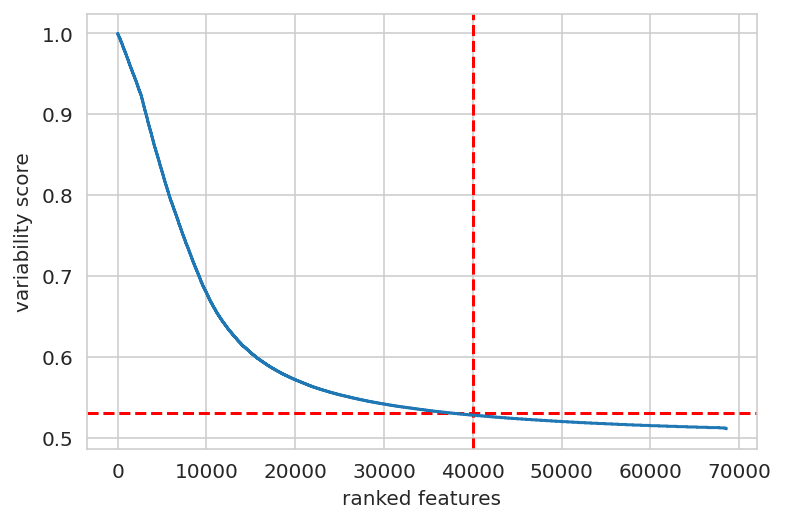

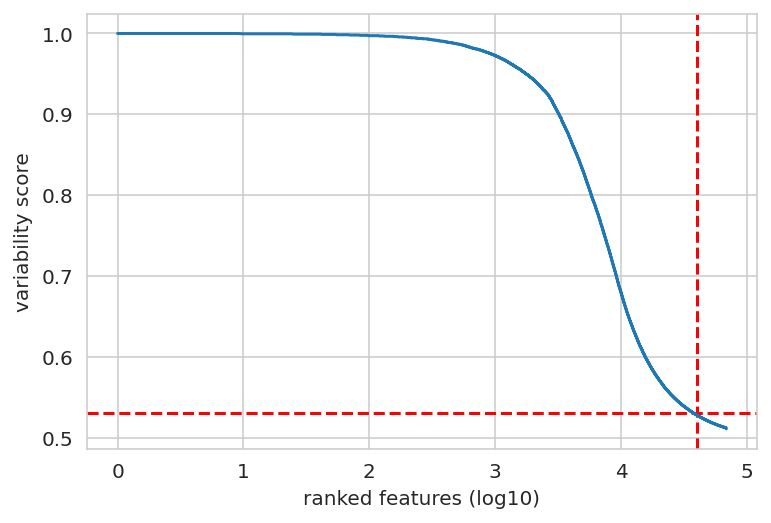

In [38]:
min_score_value = 0.53
nb_feature_selected = 40000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

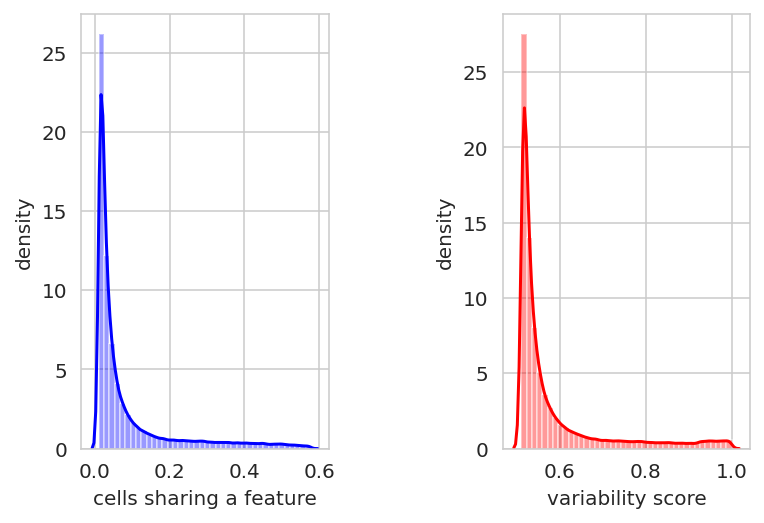

CPU times: user 1.2 s, sys: 296 ms, total: 1.5 s
Wall time: 1.49 s


In [39]:
%time epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected)

In [40]:
scatac

AnnData object with n_obs × n_vars = 2595 × 40130
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

## Normalization

In [41]:
epi.pp.normalize_total(scatac, target_sum=1e4)
epi.pp.log1p(scatac)

## Visualization

### Running UMAP

In [42]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'feature_types' as categorical
... storing 'genome' as categorical


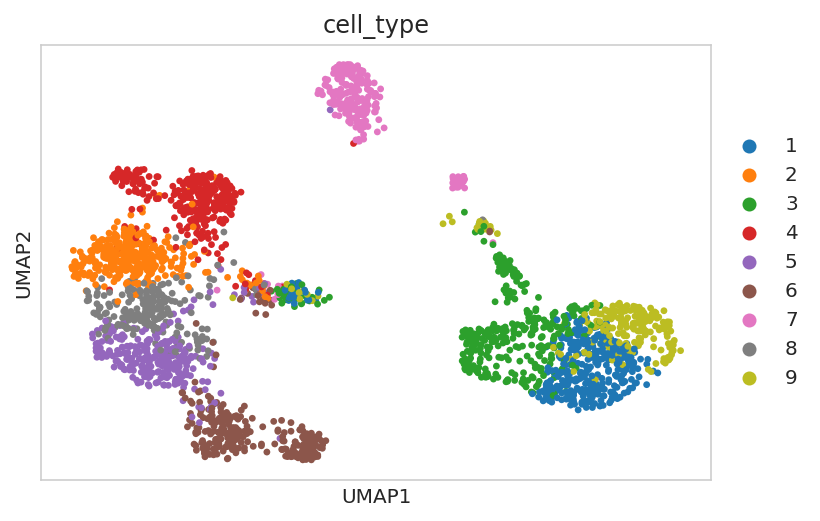

In [43]:
sc.pl.umap(scatac, color=['cell_type'])

---
# Save the results

### Find common paired samples

In [44]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(2520, 4000) (2520, 40130)


In [45]:
%time scrna.write(DATA_DIR + 'expressions.h5ad')

CPU times: user 96 ms, sys: 20 ms, total: 116 ms
Wall time: 115 ms


In [46]:
%time scatac.write_h5ad(DATA_DIR + 'peaks.h5ad')

CPU times: user 668 ms, sys: 192 ms, total: 860 ms
Wall time: 1.6 s
